In [1]:
import datetime
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
df = pd.read_csv('Stock.csv')
df .head()

,Date,Open,High,Low,Close,Volume
0,2013-01-02,17.918339,18.107130,17.846855,18.013729,102033017
1,2013-01-03,18.055573,18.229919,17.950716,18.024191,93075567
2,2013-01-04,18.165413,18.467529,18.124067,18.380356,110954331
3,2013-01-07,18.317591,18.415474,18.196297,18.300158,66476239
4,2013-01-08,18.319834,18.338762,18.043119,18.264042,67295297


In [3]:
df = df [['Date','Open','Close']] 
df ['Date'] = pd.to_datetime(df ['Date'].apply(lambda x: x.split()[0])) 
df .set_index('Date',drop=True,inplace=True) 
df .head()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2603 entries, 2013-01-02 to 2023-05-04
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2603 non-null   float64
 1   Close   2603 non-null   float64
dtypes: float64(2)
memory usage: 61.0 KB


In [4]:
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
df [df .columns] = Ms.fit_transform(df )
training_size = round(len(df ) * 0.80)
train_data = df [:training_size]
test_data  = df [training_size:]

In [5]:
def create_sequence(dataset):
    sequences=[]
    labels=[]
    start_idx=0
    for stop_idx in range(50,len(dataset)):
      sequences.append (dataset.iloc[ start_idx:stop_idx])
      labels.append(dataset.iloc[stop_idx])
      start_idx += 1
    return (np.array(sequences),np.array(labels)) 

In [6]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [7]:
len(test_seq)

471

In [8]:
np.shape(train_seq)

(2032, 50, 2)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.fit(train_seq, train_label, epochs=10,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/10
64/64 [==============================] - 7s 49ms/step - loss: 0.0037 - mean_absolute_error: 0.0341 - val_loss: 0.0020 - val_mean_absolute_error: 0.0373
Epoch 2/10
64/64 [==============================] - 2s 31ms/step - loss: 2.7728e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0018 - val_mean_absolute_error: 0.0349
Epoch 3/10
64/64 [==============================] - 2s 29ms/step - loss: 2.8435e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0020 - val_mean_absolute_error: 0.0348
Epoch 4/10
64/64 [==============================] - 2s 30ms/step - loss: 2.5298e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0018 - val_mean_absolute_error: 0.0333
Epoch 5/10
64/64 [==============================] - 2s 30ms/step - loss: 2.6187e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0014 - val_mean_absolute_error: 0.0305
Epoch 6/10
64/64 [==============================] - 2s 29ms/step - loss: 2.5857e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0013 - val_mean_absolute_error: 0.0295
Ep

In [12]:
test_predicted = model.predict(test_seq)
test_inverse_predicted = Ms.inverse_transform(test_predicted)

15/15 [==============================] - 1s 10ms/step


In [13]:
len(test_predicted)

471

In [14]:
merged_data = pd.concat([df .iloc[-(len(test_predicted)):].copy(),pd.DataFrame(test_inverse_predicted,columns=['Open_predicted','Close_predicted'],index=df .iloc[-(len(test_predicted)):].index)], axis=1)

In [15]:
merged_data[['Open','Close']] = Ms.inverse_transform(merged_data[['Open','Close']])
merged_data.head(10)
merged_data.info

<bound method DataFrame.info of                   Open       Close  Open_predicted  Close_predicted
Date                                                               
2021-06-22  126.449997  126.999496      126.087814       126.366341
2021-06-23  126.550003  126.461502      126.324326       126.628777
2021-06-24  127.053497  127.281998      126.525482       126.854622
2021-06-25  126.957001  126.995003      126.736847       127.084183
2021-06-28  127.000000  126.819504      126.923470       127.287758
...                ...         ...             ...              ...
2023-04-28  107.800003  108.220001      107.227409       107.792839
2023-05-01  107.720001  107.709999      107.337814       107.894714
2023-05-02  107.660004  105.980003      107.503555       108.041306
2023-05-03  106.220001  106.120003      107.642471       108.163368
2023-05-04  106.160004  105.309998      107.709419       108.226471

[471 rows x 4 columns]>

In [16]:
merged_data.tail(10)

,Open,Close,Open_predicted,Close_predicted
Date,,,,
2023-04-21,106.089996,105.910004,107.509354,107.946014
2023-04-24,106.050003,106.779999,107.445549,107.924118
2023-04-25,106.610001,104.610001,107.414810,107.922417
2023-04-26,105.559998,104.449997,107.361351,107.890472
2023-04-27,105.230003,108.370003,107.254517,107.806015
2023-04-28,107.800003,108.220001,107.227409,107.792839
2023-05-01,107.720001,107.709999,107.337814,107.894714
2023-05-02,107.660004,105.980003,107.503555,108.041306
2023-05-03,106.220001,106.120003,107.642471,108.163368


In [17]:
import matplotlib.pyplot as plt

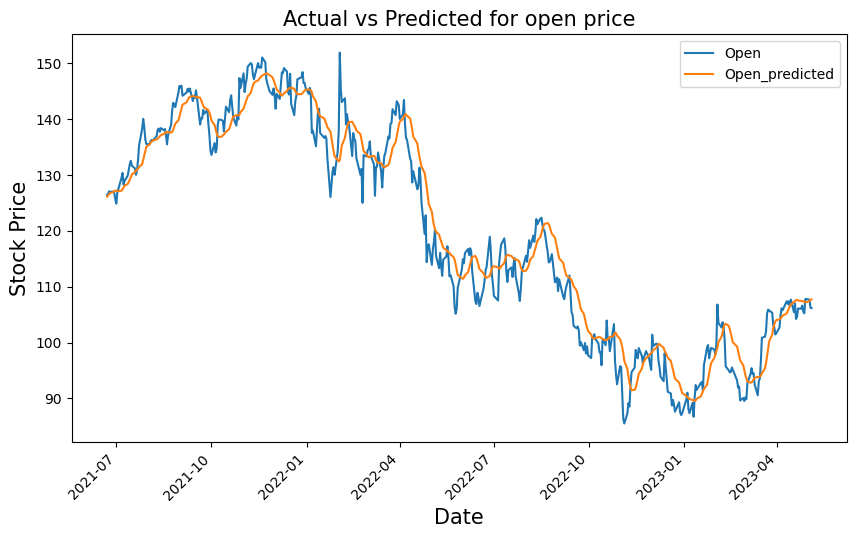

In [18]:
merged_data[['Open','Open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

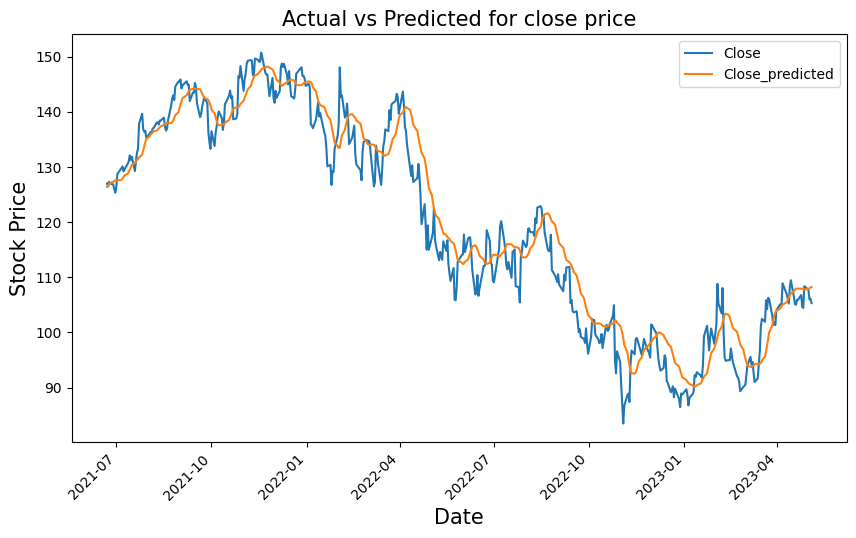

In [19]:
merged_data[['Close','Close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()